## بسم الله الرحمن الرحيم

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import collections
import zipfile

In [2]:
with zipfile.ZipFile("Teeth DataSet.zip" , 'r') as zip_ref:
    zip_ref.extractall("Teeth DataSet")

In [3]:
# Loading the dataset
dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory = r"/content/Teeth DataSet/Teeth_Dataset/Training",
    labels = "inferred",
    label_mode = 'categorical',
    image_size = (256 , 256),
    batch_size = 32,
    shuffle = True
)

Found 3087 files belonging to 7 classes.


In [4]:
dataset_valid = tf.keras.utils.image_dataset_from_directory(
    directory = r"/content/Teeth DataSet/Teeth_Dataset/Validation",
    labels = "inferred",
    label_mode = 'categorical',
    image_size = (256 , 256),
    batch_size = 32,
    shuffle = True
)

Found 1028 files belonging to 7 classes.


In [5]:
dataset_test = tf.keras.utils.image_dataset_from_directory(
    directory = r"/content/Teeth DataSet/Teeth_Dataset/Testing",
    labels = "inferred",
    label_mode = 'categorical',
    image_size = (256 , 256),
    batch_size = 32,
    shuffle = True
)

Found 1028 files belonging to 7 classes.


In [6]:
for images, labels in dataset_train.take(1):
    print("Shape of images:", images.shape)
    print("Shape of labels:", labels.shape)
    print("Label example:", labels[0].numpy())

classes = dataset_test.class_names
print("Classes:", classes)

Shape of images: (32, 256, 256, 3)
Shape of labels: (32, 7)
Label example: [0. 0. 0. 0. 0. 1. 0.]
Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


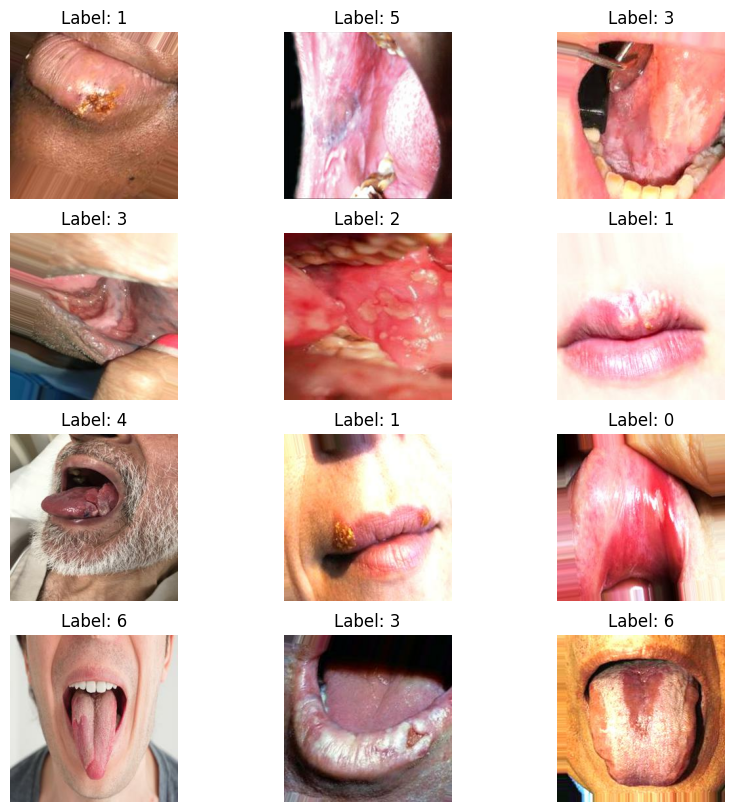

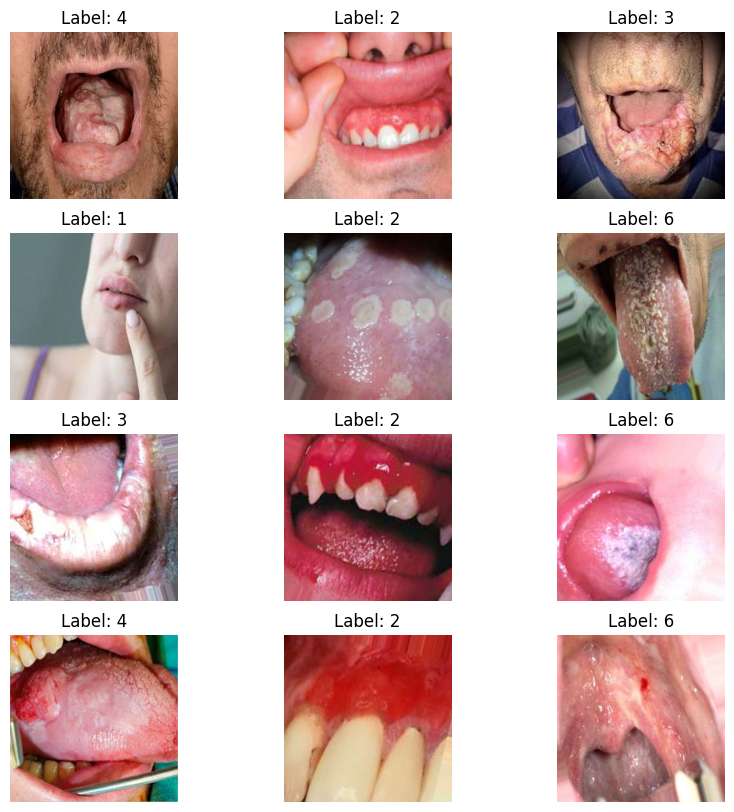

In [7]:
for images, labels in dataset_train.take(2): # take 2 batches (every batch has 32 images after shuffling)
    plt.figure(figsize=(10, 10))
    for i in range(12):
        plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy().argmax()}")
        plt.axis("off")
    plt.show()

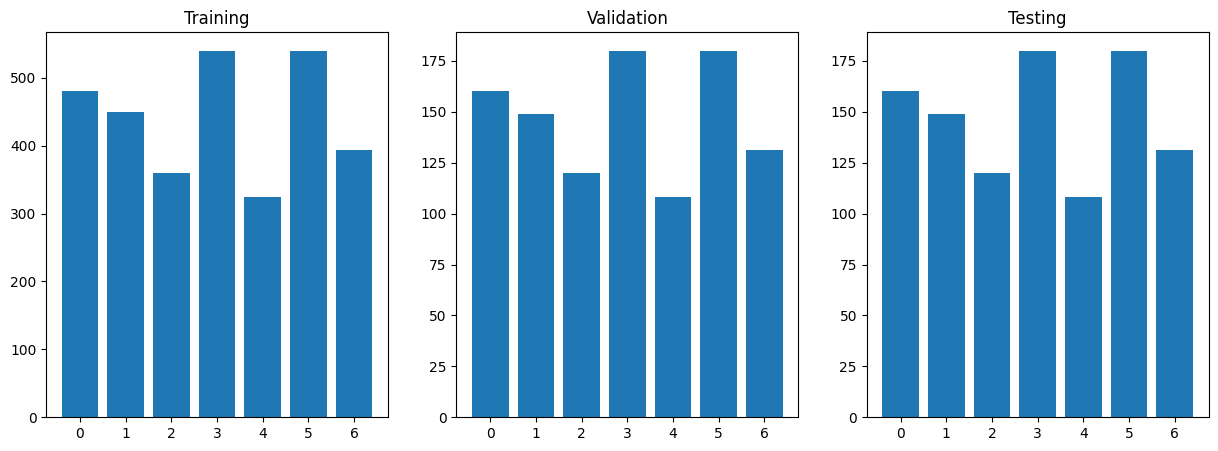

In [8]:
# check the distribution of the classes

def print_classes (dataset):
    label_counts = collections.Counter()

    for _, labels in dataset.unbatch():
        label = labels.numpy().argmax()
        label_counts[label] += 1

    return label_counts
labels_train = print_classes(dataset_train)
labels_valid = print_classes(dataset_valid)
labels_test = print_classes(dataset_test)

fig , ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(labels_train.keys(), labels_train.values())
ax[1].bar(labels_valid.keys(), labels_valid.values())
ax[2].bar(labels_test.keys(), labels_test.values())

ax[0].set_title("Training")
ax[1].set_title("Validation")
ax[2].set_title("Testing")

plt.show()

In [9]:
# apply normalization

def apply_normalization (dataset):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return dataset.map(lambda x, y: (normalization_layer(x), y))

dataset_train = apply_normalization(dataset_train)
dataset_valid = apply_normalization(dataset_valid)
dataset_test = apply_normalization(dataset_test)

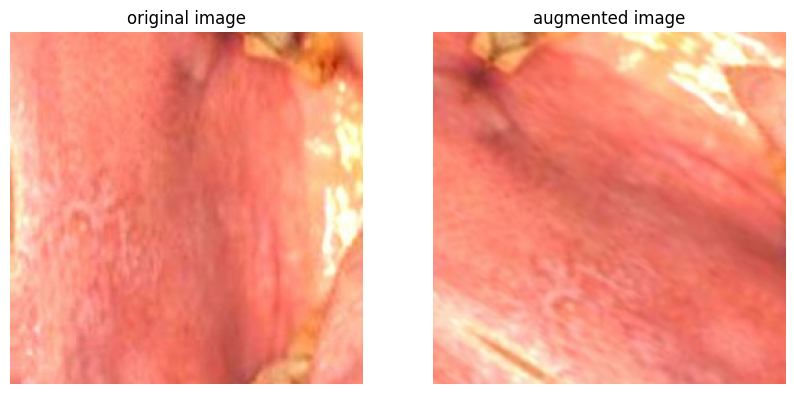

In [10]:
# augmentation (just test)
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1)
])

images , labels = next(iter(dataset_train))
augmented_images = augmentation(images)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[0].numpy())
plt.title(f"original image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented_images[0].numpy())
plt.title(f"augmented image")
plt.axis("off")
plt.show()




In [11]:
# apply augmentation (just on training set)

dataset_train = dataset_train.map(lambda x, y: (augmentation(x), y))

In [12]:
# performance optimization (advanced)
AUTOTUNE = tf.data.AUTOTUNE

dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dataset_valid = dataset_valid.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
# build model

model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(256, 256, 3)),
    keras.layers.Conv2D(filters = 32 , kernel_size = (3, 3) , activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Conv2D(filters = 64 , kernel_size = (3, 3) , activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Conv2D(filters = 128 , kernel_size = (3, 3) , activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Flatten() ,
    keras.layers.Dense(128 , activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(7 , activation = 'softmax')
])

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,841,287 (56.62 MB)

 Trainable params: 14,840,583 (56.61 MB)

 Non-trainable params: 704 (2.75 KB)

None


In [14]:
# compile model

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [15]:
# train model
history = model.fit(dataset_train, epochs=50 , validation_data = dataset_valid)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 199ms/step - accuracy: 0.2298 - loss: 2.3538 - val_accuracy: 0.1556 - val_loss: 30.3950
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.3333 - loss: 1.8712 - val_accuracy: 0.1897 - val_loss: 3.4541
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.4523 - loss: 1.4874 - val_accuracy: 0.2267 - val_loss: 2.6990
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.5708 - loss: 1.1644 - val_accuracy: 0.2733 - val_loss: 3.0362
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.6486 - loss: 0.9760 - val_accuracy: 0.2685 - val_loss: 3.5692
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7136 - loss: 0.8146 - val_accuracy: 0.2451 - val_loss: 8.3164
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.6639 - loss: 0.9388 - val_accuracy: 0.3074 - val_loss: 5.3177
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8008 - loss: 0.6144 - val_accuracy: 0.4008

In [16]:
history_train = history.history

In [17]:
# evaluate the model
history_eval = model.evaluate(dataset_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5697 - loss: 2.2484


In [19]:
history_eval

[2.3771536350250244, 0.5642023086547852]

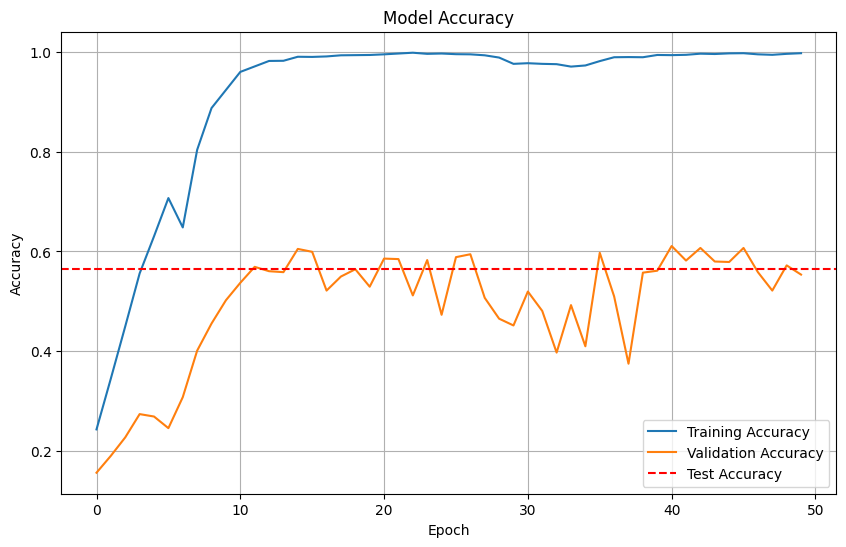

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history_train['accuracy'], label='Training Accuracy')
plt.plot(history_train['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=history_eval[1], color='red', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()